In [1]:
import os
from pathlib import Path
import glob

import torch 
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import random

from file_io import read, write
import h5py

In [2]:
class dataset(Dataset):
    def __init__(self, 
                 root,
                 input_tfm_function,
#                  gt_tfm_function,
                 input_folder_1 = "image_2", 
                 input_folder_2 = "image_2", 
                 gt_folder = "flow_occ",
                 input_search_param_1="*_10.png", 
                 input_search_param_2 = "*_11.png", 
                 gt_search_param = "*_10.png"):
        
        self.root = Path(root)
        self.input1_dir = self.root/input_folder_1
        self.input2_dir = self.root/input_folder_2
        self.gt_dir = self.root/gt_folder
        
        self.input_1_names = sorted([os.path.basename(x) for x in self.input1_dir.glob(input_search_param_1)])
        self.input_2_names = sorted([os.path.basename(x) for x in self.input2_dir.glob(input_search_param_2)])
        self.gt_names = sorted([os.path.basename(x) for x in self.gt_dir.glob(gt_search_param)])
        self.input_tfm_function = input_tfm_function
#         self.gt_tfm_function = gt_tfm_function
        
#         for a,b,c in zip(self.input_1_names,self.input_2_names,self.gt_names):
#             print(a,b,c)
        
        
    def __len__(self):
        return len(self.input_1_names)
    
    def __getitem__(self, idx):
#         print(idx)
#         print(self.input_1_names[idx],self.input_2_names[idx],self.gt_names[idx])
        input1 = read(str(self.input1_dir/self.input_1_names[idx]))
        input2 = read(str(self.input2_dir/self.input_2_names[idx]))
        gt = read(str(self.gt_dir/self.gt_names[idx]))
        
#         input1 = self.input_tfm_function(input1)
#         input2 = self.input_tfm_function(input2)
#         gt = self.gt_tfm_function(gt)
        if gt is not None:
            input1,input2,gt = self.input_tfm_function(input1,input2,gt)
        else:
            print("GT missing")
        return input1, input2, gt

In [3]:
def tn_flo_to_PIL_flow_image(flo):
    max_abs = max(flo.min(), flo.max(), key=abs)
    mean = (0, 0)
    std = (max_abs, max_abs)
    nor1_1 = transforms.Normalize(mean=mean, std=std)
    mean = (-1, -1)
    std = (2, 2)
    nor0_1 = transforms.Normalize(mean=mean, std=std)
    
    flo = nor1_1(flo)
    img = nor0_1(flo)
    padding = torch.zeros(1, img.shape[1], img.shape[2])
    img = torch.cat((img, padding), 0)
    
    return TF.to_pil_image(img)

In [4]:
def np_Kitti_flow_image_to_flo(flo_img):
    mean = (0, 0, 0)
    std = (255, 255, 255)
    nor0_1 = transforms.Normalize(mean=mean, std=std)
    mean = (0.5, 0.5, 0.5)
    std = (0.5, 0.5, 0.5)
    nor = transforms.Normalize(mean=mean, std=std)
    flo_img = torch.from_numpy(flo_img)
    flo_img = flo_img.permute(2,0,1)
    flo_img = nor0_1(flo_img)
    flow = nor(flo_img)
    flow = flow.permute(1,2,0)
    return flow[:,:,0:2]

In [5]:
def pil_norm_flow_image_to_flo(flo_img):
    flo_img = TF.to_tensor(flo_img)
    mean = (0.5, 0.5, 0.5)
    std = (0.5, 0.5, 0.5)
    nor = transforms.Normalize(mean=mean, std=std)
    flow = nor(flo_img)
    flow = flow.permute(1,2,0)
    return flow[:,:,0:2]

In [6]:
def pil_flow_image_to_flo(flo_img):
    flo_img = TF.to_tensor(flo_img)
    mean = (0, 0, 0)
    std = (255, 255, 255)
    nor0_1 = transforms.Normalize(mean=mean, std=std)
    mean = (0.5, 0.5, 0.5)
    std = (0.5, 0.5, 0.5)
    nor = transforms.Normalize(mean=mean, std=std)
    flo_img = nor0_1(flo_img)
    flow = nor(flo_img)
    flow = flow.permute(1,2,0)
    return flow[:,:,0:2]

In [ ]:
class FlowDatasetTransform():
    def __init__(self, norm, size=(375, 1242), crop=(320, 896), flip=0.5):
        self.norm = norm
        self.size = size
        self.crop = crop
        self.flip = flip

        mean = np.array(self.norm.mean)
        std = np.array(self.norm.std)

        self.inv_norm = transforms.Normalize(mean=-mean/std, std=1/std)

    def __call__(self, im_1, im_2, target):
        resize = transforms.Resize(size=self.size)
        
        im_1 = resize(im_1)
        im_2 = resize(im_2)
        target = resample_flow(target, self.size)

        # i, j, h, w = transforms.RandomCrop.get_params(im_1, output_size=self.crop)
        i, j, h, w = 0, 0, self.crop[0], self.crop[1]

        im_1 = TF.crop(im_1, i, j, h, w)
        im_2 = TF.crop(im_2, i, j, h, w)
        target = target[i:i+h,j:j+w,:]

        if False: # random.random() > self.flip:
            im_1 = TF.hflip(im_1)
            im_2 = TF.hflip(im_2)
            target = cv2.flip(target, 1)

        target = target.transpose((2, 0, 1))

        im_1 = TF.to_tensor(im_1)
        im_2 = TF.to_tensor(im_2)
        target = torch.Tensor(target)

        return norm(im_1), norm(im_2), target

    def denorm(self, im):
        return self.inv_norm(im)

In [7]:
class FlowDatasetTransform_2():
    def __init__(self, norm, size=(375, 1242), crop=(320, 896), flip=.5):
        self.norm = norm
        self.size = size
        self.crop = crop
        self.flip = .5

        mean = np.array(self.norm.mean)
        std = np.array(self.norm.std)

        self.inv_norm = transforms.Normalize(mean=-mean*std, std=1/std)

    def __call__(self, im_1, im_2, target):
#         to_PIL = transforms.ToPILImage()
        resize = transforms.Resize(size=self.size)
     
        
        norm_Pil = False
        
        if type(target) is np.ndarray:
            if(target.shape[2] is 3): #png
                c = TF.to_pil_image(np.uint8(target))
            else: #flo
                v = torch.from_numpy(target)
                v = v.permute(2,0,1)
                c = tn_flo_to_PIL_flow_image(v)
                norm_Pil = True
        
        if type(c) is not PIL.Image.Image:
            print("error")
            raise Exception('target_type not PIL');
            
            
        
#         print(im_1)
        a = TF.to_pil_image(np.uint8(im_1))
        b = TF.to_pil_image(np.uint8(im_2))
        
        

        im_1 = resize(a)
        im_2 = resize(b)
        target = resize(c)
        
        
#         if type(target) is not PIL.PngImagePlugin.PngImageFile:
#             target = TF.to_tensor(target)
#             if target.shape[0] == 2:
#                 padding = torch.zeros(1, target.shape[1], target.shape[2])
#                 target = torch.cat((target, padding), 0)
#             target = to_PIL(target)

        i, j, h, w = transforms.RandomCrop.get_params(im_1, output_size=self.crop)

        im_1 = TF.crop(im_1, i, j, h, w)
        im_2 = TF.crop(im_2, i, j, h, w)
        target = TF.crop(target, i, j, h, w)
        

        if random.random() > self.flip:
            im_1 = TF.hflip(im_1)
            im_2 = TF.hflip(im_2)
            target = TF.hflip(target)

        im_1 = TF.to_tensor(im_1)
        im_2 = TF.to_tensor(im_2)
#         target = TF.to_tensor(target)
#         if(norm_Pil is True):
        target = pil_norm_flow_image_to_flo(target) #onlu if Pil was not there
#         else:
#             target = pil_flow_image_to_flo(target)
            
            
            
#        if target_type is PIL.Image.Image:
#         print(target.shape)

        return im_1, im_2, target

    def denorm(self, im):
        return self.inv_norm(im)

In [8]:
# # set the transform
# transform = transforms.Compose([
#         transforms.ToTensor(),
#         transforms.ToPILImage(),
#         transforms.Resize((512,512), interpolation=2),
#         transforms.ToTensor()
#         ])

In [9]:
mean = (.5, .5, .5)
std = (.5, .5, .5)
norm = transforms.Normalize(mean=mean, std=std)

transform = FlowDatasetTransform(norm,size=(384, 512),crop=(384,448))

In [10]:
# train_loader_kitti = dataset("../Data/KittiDataset/training",
#                        transform,
#                        input_folder_1 = "image_2", 
#                        input_folder_2 = "image_2", 
#                        gt_folder = "flow_occ",
#                        input_search_param_1="*_10.png", 
#                        input_search_param_2 = "*_11.png", 
#                        gt_search_param = "*_10.png")

In [11]:
train_loader_FlyingChairs = dataset("../Data/FlyingChairs_release",
                       transform,
                       input_folder_1 = "data", 
                       input_folder_2 = "data", 
                       gt_folder = "data",
                       input_search_param_1="*_img1.ppm", 
                       input_search_param_2 = "*_img2.ppm", 
                       gt_search_param = "*_flow.flo")

In [12]:
# dataset_kitti = torch.utils.data.DataLoader(train_loader_kitti,4,shuffle=True,num_workers=2)

In [13]:
dataset_flyingChairs = torch.utils.data.DataLoader(train_loader_FlyingChairs,batch_size=8,shuffle=True,num_workers=2)

In [14]:
def write_H5(dataset, path):
    index = 0
    for inputs1,inputs2,target in dataset:
#         print(index)
        with h5py.File(path + str(index), 'w') as f:
            in1 = f.create_dataset('img1', dtype=np.float32,data=inputs1,compression="gzip", compression_opts=9)
            in2 = f.create_dataset('img2', dtype=np.float32,data=inputs2,compression="gzip", compression_opts=9)    
#             flo = pil_norm_flow_image_to_flo(target)
            targ = f.create_dataset('target', dtype=np.float32,data=target,compression="gzip", compression_opts=9)
            index+=1

In [15]:
def read_H5(index, path):
    with h5py.File(path + str(index), 'r') as f:
        img1 = f["img1"][()]
        img2 = f["img2"][()]
        trg = f["target"][()]
        img1_file = torch.from_numpy(img1)
        img2_file = torch.from_numpy(img2)
        target_file = torch.from_numpy(trg)
        return img1_file,img2_file,target_file

In [16]:
def print_batch(im1,im2,target):
    for image_1, image_2, target_image in zip(im1,im2,target):
        im1_print = image_1.numpy().transpose((1,2,0))
        im2_print = image_2.numpy().transpose((1,2,0))
        
#         print(target_image.shape)

#         z = np.zeros((target_image.shape[1],target_image.shape[2]))
#         target_print = np.stack((target_image[0],target_image[1], z), axis=0)
#         target_print = target_print.transpose((1,2,0))
#         print(target_print.shape)
#         print(target_image.shape)
        print(target_image.shape)
#         padding = torch.zeros(target_image.shape[0], target_image.shape[1],1)
# #         print(padding.shape)
#         target_image = torch.cat((target_image, padding), 2)
    
        print(torch.max(target_image))
        print(torch.min(target_image))
        print(target_image.shape)
        
        target_image = target_image.permute(2,0,1)
        target_print=tn_flo_to_PIL_flow_image(target_image)

        fig, ax = plt.subplots(1, 3, figsize=(15, 20))
        for a in ax:
          a.set_axis_off()

        ax[0].imshow(im1_print)
        ax[1].imshow(im2_print)
        ax[2].imshow(target_print)

        plt.show()

In [17]:
# write_H5(dataset_kitti, path = '../Data/H5/512by512Kitti/mini_batch_')

In [18]:
write_H5(dataset_flyingChairs, path = '../Data/H5/FlyingChairs2/mini_batch_')

torch.Size([384, 448, 2])
tensor(1.)
tensor(-0.5843)
torch.Size([384, 448, 2])


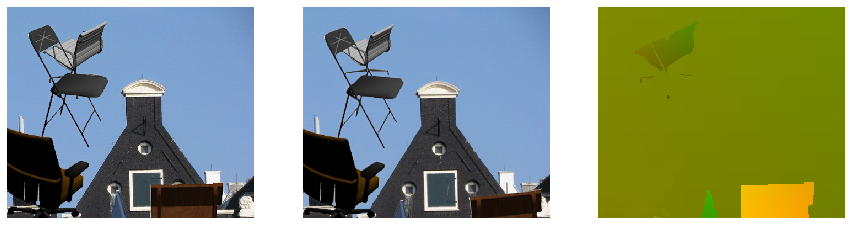

torch.Size([384, 448, 2])
tensor(1.)
tensor(-0.5216)
torch.Size([384, 448, 2])


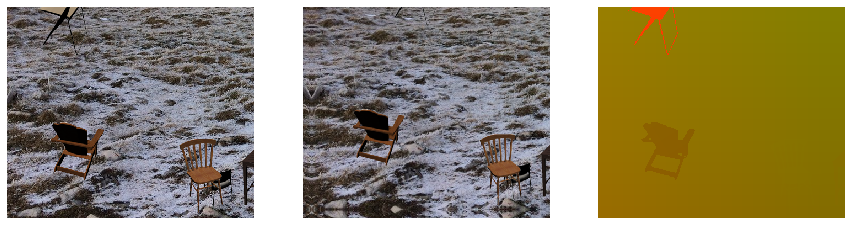

torch.Size([384, 448, 2])
tensor(0.9216)
tensor(-0.6314)
torch.Size([384, 448, 2])


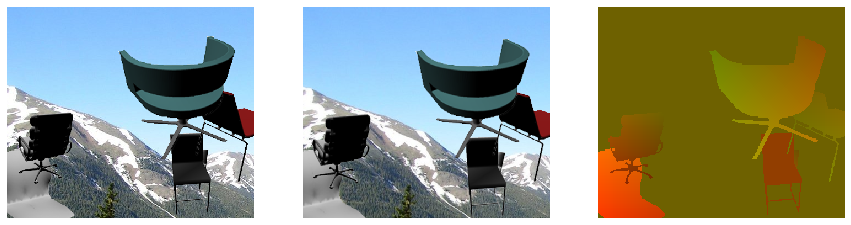

torch.Size([384, 448, 2])
tensor(1.)
tensor(-0.8196)
torch.Size([384, 448, 2])


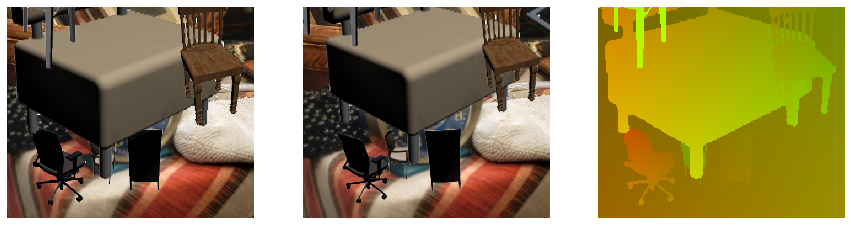

torch.Size([384, 448, 2])
tensor(1.)
tensor(-0.3725)
torch.Size([384, 448, 2])


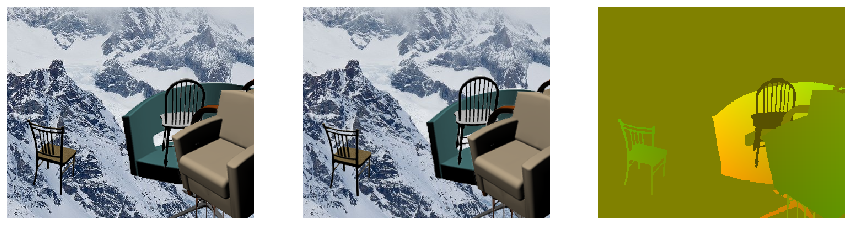

torch.Size([384, 448, 2])
tensor(1.)
tensor(-0.5294)
torch.Size([384, 448, 2])


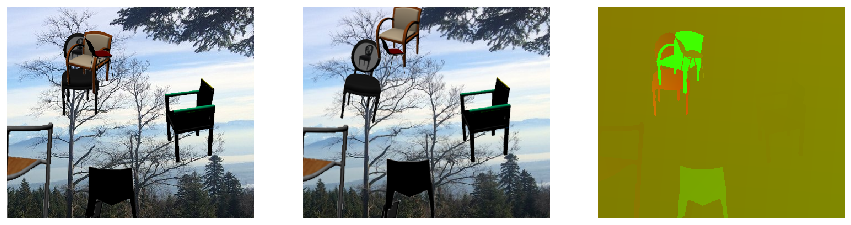

torch.Size([384, 448, 2])
tensor(0.1843)
tensor(-0.2314)
torch.Size([384, 448, 2])


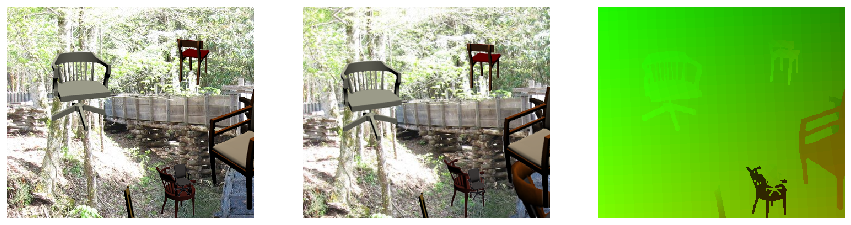

torch.Size([384, 448, 2])
tensor(1.)
tensor(-0.6392)
torch.Size([384, 448, 2])


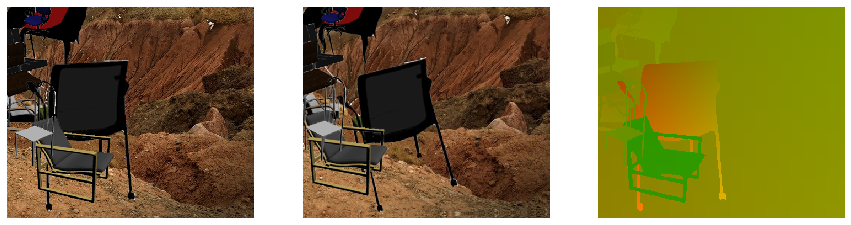

In [19]:
im1,im2,target = read_H5(0,path = '../Data/H5/FlyingChairs2/mini_batch_')
print_batch(im1,im2,target)

In [20]:
read("../Data/ChairsSDHom_extended/train/0004142-flow_01.flo")

FileNotFoundError: [Errno 2] No such file or directory: '../Data/ChairsSDHom_extended/train/0004142-flow_01.flo'

In [ ]:
read("../Data/ChairsSDHom_extended/train/0007785-img_1.png")

In [ ]:
root = Path("../Data/ChairsSDHom_extended/train/0004142-flow_01.flo")

In [ ]:
s = os.path.basename(root)
dir = Path(os.path.dirname(root))
s = s.replace('-flow_01.flo', '')
im = s + '-img_0.png'
ir = s + '-img_1.png'
print(dir/im)
print(dir/ir)


print(s)


In [ ]:
u = Image.open('../Data/ChairsSDHom_extended/train/0010306-img_1.png')
print(u)
type(u)
# resize = transforms.Resize((100,100))
# resize(u)
# u.show()
# print(u.width)

In [ ]:
# import cv2

In [ ]:
print(u)

In [ ]:
# cv2.imread('../Data/ChairsSDHom_extended/train/0004050-img_1.png')